# AIM
- It is a known issue that sleep stage intervals outputted by FitBit contains overlap. Some may be the same label (duplication) but some are now
- This notebook investigate this problem in the data quality

# RESULTS
- Only a small proportion of sleep stage data contains overlap
- A routine to remove the overlap was engineered

In [13]:
##### MODULES
import os
import numpy as np
import pandas as pd
from pathlib import Path
from matplotlib import pyplot as plt
import matplotlib.dates
import matplotlib.patches
import datetime as dt

# custom modules
import sys  
sys.path.append('../../scripts')

from import_data import *
from clean_data import *
from mappings import *
from plotting import *

##### OPTIONS
pd.options.mode.chained_assignment = None

# autoreload external modules after saving changes to disk
%reload_ext autoreload
%autoreload 2

proj_dir = Path('.') / '..' / '..'
source_data_dir = proj_dir/'data'/'source'
clean_data_dir =  proj_dir/'data'/'clean'
viz_dir = proj_dir/'viz'

In [14]:
import feather

# Import/Clean or Load from Disk

### Cleaning

In [15]:
LOAD_FROM_DISK = True

if LOAD_FROM_DISK:
    timeseries = pd.read_feather(clean_data_dir/'slps_timeseries.ftr')
    intervals = pd.read_feather(clean_data_dir/'slps_interval_clean.ftr')
    _, _, metadata = import_data(source_data_dir)
    
else:
    phqs_raw, slps_raw, metadata = import_data(source_data_dir)
    intervals = clean_slps(slps_raw)
    timeseries = explode2ts(intervals, ID='intervalID', start='start', end='end')

    outpath = proj_dir / 'data' / 'clean' / 'slps_interval_clean.ftr'
    feather.write_feather(intervals, outpath)
    
    outpath = proj_dir / 'data' / 'clean' / 'slps_timeseries.ftr'
    feather.write_feather(timeseries, outpath)

ArrowNotImplementedError: Support for codec 'lz4' not built

Depth analysis

In [7]:
### count depth/overlapping timestamps
tsmerge = pd.merge(
    timeseries, 
    intervals[['pid', 'intervalID']], 
    on='intervalID'
)
tsmerge['depth'] = tsmerge.groupby(['pid', 't']).cumcount()+1


In [126]:
def get_dup_percent(df):
    ### not perfect, wrong formula but a general idea
    return ( (df['depth']>1).sum() / len(df) )*100

pids = list(set(intervals['pid']))

tsmerge.groupby('pid').agg(x=('depth', np.mean))


,x
pid,
007751c5-d7ad-4bec-a58f-abf32500e2ae,1.000000
0104dfff-4dcd-48ff-b912-51362f098ed0,1.000000
01318193-bb33-4c1b-b1bf-d316a014b5ad,1.000000
0157930f-10f7-4d5f-9575-a65efbd1d505,1.000000
02919d70-343c-4efa-97c0-c34bf85546f0,1.000825
...,...
fa570b90-38af-4fbd-8dac-42649b93f1c9,1.000000
fb62039c-0b79-4be0-a7b9-ebf5d926eff2,1.000000
fbcf7045-e013-4d0d-9f0e-139df2c3b332,1.000000


In [134]:
pid_with_dup = set(tsmerge.loc[tsmerge['depth']>1, 'pid'])
pids = set(intervals['pid'])

n_pid_with_dup = len(pid_with_dup)
n_pid = len(pids)
print(n_pid_with_dup, 'out of', n_pid, 'subjects have duplication')

122 out of 461 subjects have duplication


In [138]:
pid_without_dup = pids.difference(pid_with_dup)
with open(clean_data_dir/'pid_without_dup.txt','w') as f:
   f.write(str(pid_without_dup)) 

### Cleaning routine

- Step 1: try with one patient

In [1]:
date_select = dt.date(2018, 11, 12)
pid_select  = "3c6671b8-45ae-4552-b92b-934ec6bbb89f"
df = intervals.query("start_date == @date_select & pid == @pid_select")

NameError: name 'dt' is not defined

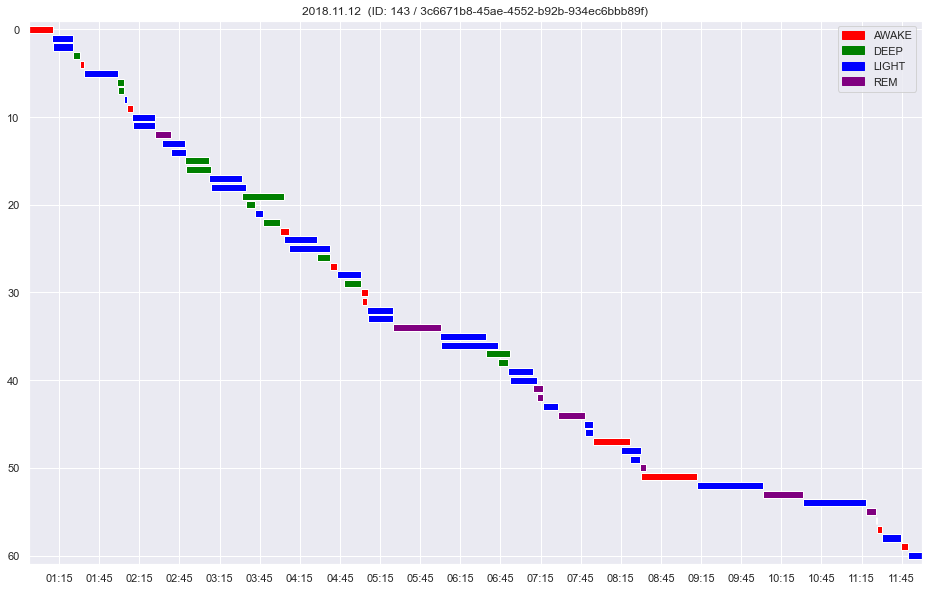

In [140]:
fig = plot_gannt(df, metadata);
fig.savefig(proj_dir/'viz'/'gannt_dup.png')

In [65]:
ts = explode2ts(df)
ts_merged = ts.merge(intervals, on='intervalID')

In [66]:
depth = ts_merged.groupby(['pid','t']).cumcount()+1
depth.value_counts()

1    1335
2     603
dtype: int64

In [68]:
times_with_repeated_obs = set(ts_merged.loc[depth>1, 't'])

In [71]:
ts_full = dedup_ts(ts_merged, times_with_repeated_obs)
ts_full = ts_full.sort_values('t')
ts_full = ts_full[['t','stages','pid']]

# timestamps by depth after dedup
( ts_full.groupby(['pid', 't']).cumcount()+1 ).value_counts()

1    1335
dtype: int64

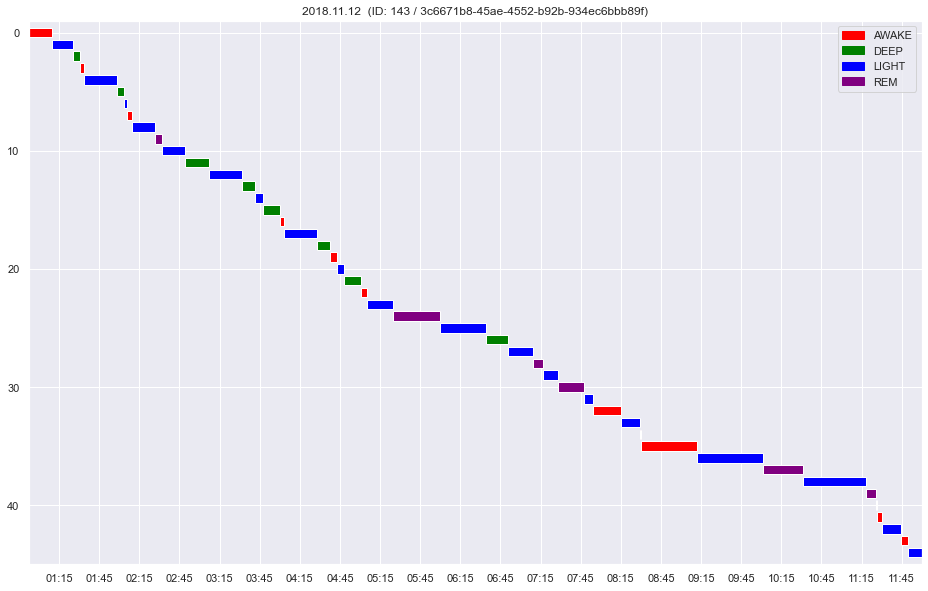

In [79]:
out = ts2interval(ts_full)
out['pid'] = pid_select
out['end'] = out['end']  + dt.timedelta(seconds=30)
out['start_date'] = date_select
fig = plot_gannt(out, metadata);
fig.savefig(viz_dir/'gannt_dedup.png')

# To-do's

1. Overlap issue (urgent)
3. Start time histogram
--- when does stages output start? At what times with any distribution?
4. Data quality across dates & subjects & centres etc? --- 1. duplication

Programming
1. understand warning:
"A value is trying to be set on a copy of a slice from a DataFrame"

Analysis design
1. Between-day, within-day, across-day patterns --> would ICC be a useful measure for EDA?
2. 

### PIDs in sleep, PHQ, and metadata

In [ ]:
out = pd.merge(slps, metadata[['ID','subject_id']], left_on='pid', right_on='subject_id', how='left')
no_metadata = out[out['ID'].isna()]
no_metadata.value_counts('pid')
# out = out.drop(['pid', 'subject_id'], axis=1)
# out = out['ID'].astype(int)

In [1]:
phqs_pid = set(phqs['pid'])
slps_pid = set(slps['pid'])
meta_pid = set(metadata['subject_id'])

import matplotlib_venn as venn
venn.venn2([slps_pid,meta_pid],set_labels=('slps','meta'))

NameError: name 'phqs' is not defined